# CAICLE Rider Performance Modeling (2017–2021)

**Goal:** Predict if a rider finishes **Top 30** in a race.  
**Target:** `target = 1` → Top 30, `target = 0` → Outside Top 30.

**Models compared:**
- RandomForestClassifier
- LightGBM (LGBMClassifier)
- CatBoostClassifier

**IMPORTANT: Imbalanced data.**  
Main metric = **Balanced Accuracy (Per-Class Accuracy)**.  
Also **emphasize Recall for class 1** (Top 30), per team guidance.

**Data:** Cleaned yearly CSVs: `cleaned_data_2017.csv` … `cleaned_data_2021.csv`.

**Splits:** Train 70% | Validation 15% | Test 15% (all stratified).

**I will report:**
 - Balanced accuracy (per-class accuracy)  <-- main
 - Precision / Recall / F1 for Top30 class (class 1)
 - Confusion matrix
 - Feature importance

**Author:** Youri van der Meulen
**Data prep:** Christian (cpm)
**Date:** October 2025

In [1]:

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns  # only for heatmap style plots; if this errors remove seaborn usage


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# For reproducibility
RANDOM_STATE = 42


## 1. Load & combine all years (2017-2021)

In [2]:

file_paths = sorted(glob.glob("data/cleaned_data_20*.csv")) # matches cleaned_data_2017.csv ... cleaned_data_2021.csv
if not file_paths:
    raise FileNotFoundError("No files found matching cleaned_data_20*.csv in the current folder.")

dfs = [pd.read_csv(fp) for fp in file_paths]
df = pd.concat(dfs, ignore_index=True)

print("Files:", file_paths)
print("Combined shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Files: ['data/cleaned_data_2017.csv', 'data/cleaned_data_2018.csv', 'data/cleaned_data_2019.csv', 'data/cleaned_data_2020.csv', 'data/cleaned_data_2021.csv']
Combined shape: (120261, 18)
Columns: ['target', 'GC', 'Age', 'Length', 'height', 'weight', 'One day races', 'GC_specialty', 'Time trial', 'Sprint', 'Climber', 'PCS Ranking', 'UCI World Ranking', 'Specials | All Time Ranking', 'sumres_1', 'sumres_2', 'sumres_3', 'Stage_Type_RR']


,target,GC,Age,Length,height,weight,One day races,GC_specialty,Time trial,Sprint,Climber,PCS Ranking,UCI World Ranking,Specials | All Time Ranking,sumres_1,sumres_2,sumres_3,Stage_Type_RR
0,1,1.0,22.0,118.5,1.670,69.0,297.0,1214.0,1221.0,511.0,500.0,775.0,565.0,1142.0,500.0,123.0,33.0,1.0
1,1,2.0,23.0,118.5,1.840,82.0,98.0,612.0,70.0,21.0,460.0,299.0,491.0,985.0,160.0,177.0,77.0,1.0
2,1,3.0,26.0,118.5,1.780,73.0,350.0,411.0,1.0,262.0,248.0,473.0,1873.0,985.0,67.0,46.0,52.0,1.0
3,1,8.0,28.0,118.5,1.806,68.6,861.5,856.0,417.5,900.0,779.0,520.0,861.0,985.0,32.0,107.7,5.0,1.0
4,1,9.0,23.0,118.5,1.760,72.0,861.5,856.0,417.5,900.0,779.0,520.0,861.0,985.0,186.0,212.0,5.0,1.0


## 2. Basic sanity checks

In [3]:

# class balance
class_counts = df['target'].value_counts().sort_index()
class_ratio = class_counts / len(df)

print("Class counts:\n", class_counts)
print("\nClass ratio:\n", class_ratio)

# check for missing values
missing_counts = df.isna().sum()
print("\nMissing values per column:\n", missing_counts)

# dtype check
print("\nDtypes:\n", df.dtypes)


Class counts:
 target
0    95596
1    24665
Name: count, dtype: int64

Class ratio:
 target
0    0.794904
1    0.205096
Name: count, dtype: float64

Missing values per column:
 target                         0
GC                             0
Age                            0
Length                         0
height                         0
weight                         0
One day races                  0
GC_specialty                   0
Time trial                     0
Sprint                         0
Climber                        0
PCS Ranking                    0
UCI World Ranking              0
Specials | All Time Ranking    0
sumres_1                       0
sumres_2                       0
sumres_3                       0
Stage_Type_RR                  0
dtype: int64

Dtypes:
 target                           int64
GC                             float64
Age                            float64
Length                         float64
height                         float64
weight     

## 3. Train/Val/Test split (stratified 70/15/15)

In [4]:
# Separate the predictors (X) from the target variable (y)
# X = all columns except 'target'
# y = the 'target' column (1 = Top30 finish, 0 = otherwise)
X = df.drop(columns=['target'])
y = df['target']
# Store column names for later use
feature_names = X.columns.tolist()

# Use of stratified sampling to preserve class balance (21% Top30, 79% not Top30)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)
# Half of the temporary set becomes validation, half becomes test.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)
# Summary of splits
print("Train size:", len(X_train), "| Val size:", len(X_val), "| Test size:", len(X_test))
print("Class dist (train):\n", y_train.value_counts(normalize=True).sort_index())
print("Class dist (val):\n", y_val.value_counts(normalize=True).sort_index())
print("Class dist (test):\n", y_test.value_counts(normalize=True).sort_index())

Train size: 84182 | Val size: 18039 | Test size: 18040
Class dist (train):
 target
0    0.794909
1    0.205091
Name: proportion, dtype: float64
Class dist (val):
 target
0    0.794889
1    0.205111
Name: proportion, dtype: float64
Class dist (test):
 target
0    0.7949
1    0.2051
Name: proportion, dtype: float64


## 4. Evaluation helper (Balanced Accuracy + Recall for class 1)

In [5]:

import matplotlib.pyplot as plt

def evaluate_model(model_name, y_true, y_pred):
    """
    Evaluate a classification model with metrics suited for imbalanced data.

    Metrics shown:
    - Balanced Accuracy (Per-Class Accuracy)
    - Recall (class 1 = Top 30 riders)
    - F1 Score (class 1)
    - Full classification report
    - Confusion matrix plot
    """

    # Compute main metrics
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    rec1 = recall_score(y_true, y_pred, pos_label=1)
    f1_1 = f1_score(y_true, y_pred, pos_label=1)
    # Print metrics summary
    print(f"==================== {model_name} ====================")
    print(f"Balanced Accuracy (Per-Class Accuracy): {bal_acc:.4f}")
    print(f"Recall (Top 30, class=1): {rec1:.4f}\n")
    print(f"F1 Score (Top 30, class=1): {f1_1:.4f}\n")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    # Plot confusion matrix if seaborn present; otherwise basic matplotlib
    plt.figure(figsize=(4,3))
    if sns is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred 0','Pred 1'],
                    yticklabels=['True 0','True 1'])
    else:
        plt.imshow(cm, cmap='Blues')
        for (i,j), val in np.ndenumerate(cm):
            plt.text(j, i, str(val), ha='center', va='center')
        plt.xticks([0,1], ['Pred 0','Pred 1'])
        plt.yticks([0,1], ['True 0','True 1'])

    plt.title(f"{model_name} - Confusion Matrix (Test)")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    # --- Return results for summary table ---
    return bal_acc, rec1, f1_1


## 5a. Random Forest

==================== Random Forest ====================
Balanced Accuracy (Per-Class Accuracy): 0.7200
Recall (Top 30, class=1): 0.5086

F1 Score (Top 30, class=1): 0.5733

Classification report:
              precision    recall  f1-score   support

           0     0.8802    0.9315    0.9051     14340
           1     0.6569    0.5086    0.5733      3700

    accuracy                         0.8447     18040
   macro avg     0.7685    0.7200    0.7392     18040
weighted avg     0.8344    0.8447    0.8371     18040

Confusion matrix:
 [[13357   983]
 [ 1818  1882]]


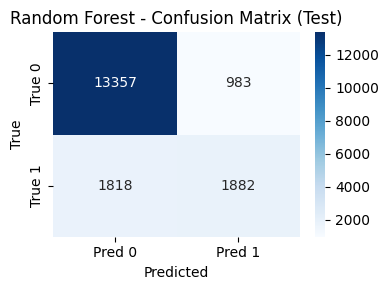

Top 15 RF features:
 GC                   0.391742
Length               0.198984
sumres_1             0.068278
sumres_2             0.049777
Age                  0.042694
sumres_3             0.041051
weight               0.024607
height               0.021402
One day races        0.019508
Sprint               0.019314
PCS Ranking          0.019002
Climber              0.018936
UCI World Ranking    0.018620
Time trial           0.018035
GC_specialty         0.017805
dtype: float64


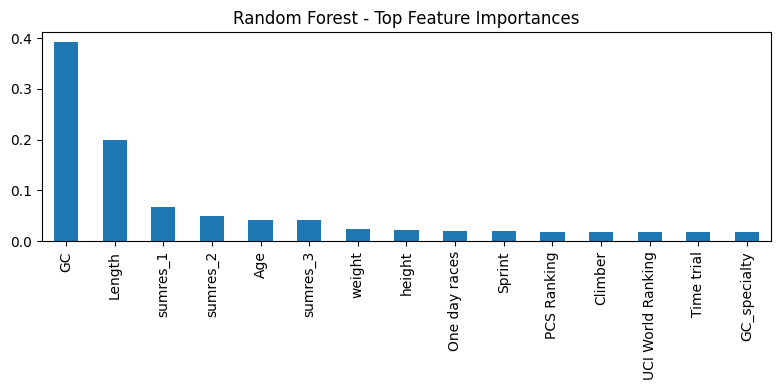

In [6]:
# Why RF here?
# - Strong general baseline for tabular data
# - Handles non-linearities & outliers

rf = RandomForestClassifier(
    n_estimators=300,           # more trees => more stable estimates
    max_depth=None,             # let trees expand; tune later if overfitting
    class_weight='balanced',    # counter class imbalance using inverse class freq
    random_state=RANDOM_STATE,  
    n_jobs=-1                   # use all CPU cores
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_bal, rf_rec, rf_f1= evaluate_model("Random Forest", y_test, rf_pred)

# Feature importances
rf_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top 15 RF features:\n", rf_imp.head(15))
rf_imp.head(15).plot(kind='bar', figsize=(8,4), title='Random Forest - Top Feature Importances')
plt.tight_layout(); plt.show()

# Optional: push Recall(class=1) higher later,
# tune the classification threshold using validation probabilities, e.g.:
# rf_val_proba = rf.predict_proba(X_val)[:, 1]
# ...search threshold on X_val that maximizes recall or F1 for class 1,
# then apply that threshold to X_test probabilities for final predictions.

## 5b. LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17265, number of negative: 66917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3235
[LightGBM] [Info] Number of data points in the train set: 84182, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
==================== LightGBM ====================
Balanced Accuracy (Per-Class Accuracy): 0.7892
Recall (Top 30, class=1): 0.7416

F1 Score (Top 30, class=1): 0.6248

Classification report:
              precision    recall  f1-score   support

           0     0.9262    0.8368    0.8792     14340
           1     0.5397    0.7416    0.6248      3700

    accuracy                         0.8173     18040
   macro avg     

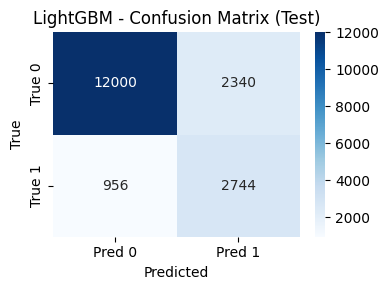

Top 15 LGBM features:
 Length               2819
GC                   2120
sumres_1             1036
sumres_2              915
sumres_3              830
Age                   762
weight                752
height                721
Sprint                701
UCI World Ranking     626
PCS Ranking           621
Time trial            619
Climber               608
GC_specialty          583
One day races         517
dtype: int32


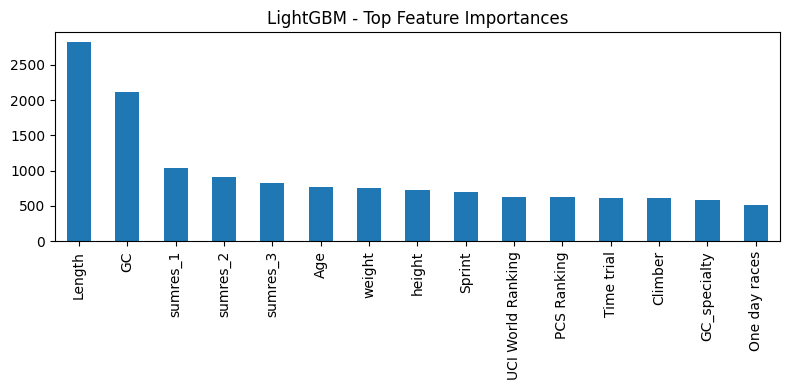

In [7]:
# Why LightGBM?
# - Usually top performer on tabular data
# - Fast, handles large datasets well

lgbm = LGBMClassifier(
    n_estimators=500,           # more trees; tune later with val set
    learning_rate=0.05,         # smaller lr + more trees is a good starting point
    max_depth=-1,               # let trees grow; tune if overfitting
    subsample=0.8,              # row sampling (stochastic boosting)
    colsample_bytree=0.8,       # feature sampling per tree
    class_weight='balanced',    
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_bal, lgbm_rec, lgbm_f1 = evaluate_model("LightGBM", y_test, lgbm_pred)

lgbm_imp = pd.Series(lgbm.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top 15 LGBM features:\n", lgbm_imp.head(15))
lgbm_imp.head(15).plot(kind='bar', figsize=(8,4), title='LightGBM - Top Feature Importances')
plt.tight_layout(); plt.show()

# Optional: threshold tuning for class 1 (to push recall higher)
# probs_val = lgbm.predict_proba(X_val)[:, 1]
# probs_test = lgbm.predict_proba(X_test)[:, 1]
# Choose threshold on validation set to maximize recall/F1 for class 1,
# then apply it to probs_test to get final predictions.

## 5c. CatBoost

==================== CatBoost ====================
Balanced Accuracy (Per-Class Accuracy): 0.7873
Recall (Top 30, class=1): 0.7373

F1 Score (Top 30, class=1): 0.6228

Classification report:
              precision    recall  f1-score   support

           0     0.9251    0.8374    0.8791     14340
           1     0.5391    0.7373    0.6228      3700

    accuracy                         0.8169     18040
   macro avg     0.7321    0.7873    0.7509     18040
weighted avg     0.8460    0.8169    0.8265     18040

Confusion matrix:
 [[12008  2332]
 [  972  2728]]


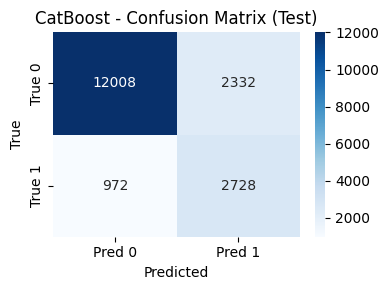

Top 15 CatBoost features:
 GC                   28.405522
Length               12.045902
sumres_1              6.338184
weight                6.184905
height                5.974497
Stage_Type_RR         5.158770
sumres_2              4.723322
Age                   4.448268
sumres_3              3.962099
Time trial            3.606473
Climber               3.386817
Sprint                3.282610
UCI World Ranking     3.111559
GC_specialty          2.648245
PCS Ranking           2.572163
dtype: float64


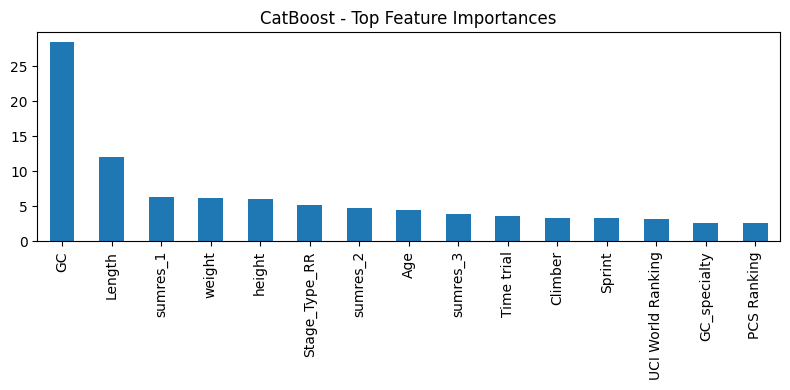

In [8]:
# Why CatBoost?
# - Handles numeric/categorical data smoothly (though ours are numeric already)
# - Automatically balances and regularizes trees
# - Often requires less hyperparameter tuning than LightGBM/XGBoost
# - Has built-in evaluation metric for Balanced Accuracy

# Compute simple class weights: give more weight to minority (class 1)
cnt = y_train.value_counts().sort_index()
neg, pos = int(cnt[0]), int(cnt[1])
class_weights = [1.0, neg / pos]    # roughly [1.0, 3.7] given 21% positive rate

cat = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function='Logloss',            # binary log loss
    eval_metric='BalancedAccuracy',     # evaluate using per-class accuracy
    random_seed=RANDOM_STATE,
    verbose=False,                      # suppress training output
    class_weights=class_weights
)
# Train using both Train and Val sets for internal monitoring
# use_best_model=True picks the iteration with best val performance
cat.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

cat_pred = cat.predict(X_test).astype(int)
cat_bal, cat_rec, cat_f1 = evaluate_model("CatBoost", y_test, cat_pred)

cat_imp = pd.Series(cat.get_feature_importance(), index=feature_names).sort_values(ascending=False)
print("Top 15 CatBoost features:\n", cat_imp.head(15))
cat_imp.head(15).plot(kind='bar', figsize=(8,4), title='CatBoost - Top Feature Importances')
plt.tight_layout(); plt.show()

# --- Notes ---
# CatBoost typically handles class imbalance quite well when class_weights are set.
# Later: tune iterations, depth, and learning_rate using the validation set
# to see if Recall (class=1) can be pushed even higher.

## 6. Summary comparison (Test set)

In [9]:

summary = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'CatBoost'],
    'BalancedAccuracy_Test': [rf_bal, lgbm_bal, cat_bal],
    'Recall_Class1_Test': [rf_rec, lgbm_rec, cat_rec],
    'F1_Class1_Test': [rf_f1, lgbm_f1, cat_f1]
}).sort_values(by='BalancedAccuracy_Test', ascending=False)
summary


,Model,BalancedAccuracy_Test,Recall_Class1_Test,F1_Class1_Test
1,LightGBM,0.789221,0.741622,0.624772
2,CatBoost,0.787338,0.737297,0.622831
0,Random Forest,0.720050,0.508649,0.573343
